<a href="https://colab.research.google.com/github/Krankile/npmf/blob/main/notebooks/parametric/univariate_statistical_forecacst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Run in an Anaconda PowerShell to allow connection from Colab

In [ ]:
pip install jupyter_http_over_ws
jupyter serverextension enable --py jupyter_http_over_ws
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0

## Kernel setup

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%%capture
!git clone https://github.com/Krankile/npmf.git
!pip install wandb
!pip install pmdarima

In [4]:
!wandb login

wandb: Currently logged in as: ankile (krankile). Use `wandb login --relogin` to force relogin


##General setup

In [28]:
%%capture
!cd npmf && git pull

import os
import json
import pickle
from collections import defaultdict
from datetime import datetime
from operator import itemgetter

import numpy as np
from numpy.ma.core import outerproduct
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm

import pmdarima as pm

import wandb as wb

from npmf.utils.colors import main, main2, main3
from npmf.utils.wandb import get_dataset, put_dataset, put_stat_models, get_stat_models
from npmf.utils.data import test_start_pd
from npmf.utils.measurement import mape

In [12]:
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=[main, main2, main3, "black"])
mpl.rcParams['figure.figsize'] = (6, 4)  # (6, 4) is default and used in the paper

In [13]:
np.random.seed(69)

In [14]:
def plot_market_cap(df):
    plt.plot(df.date.to_numpy(), df.market_cap.to_numpy())

# Let's get the training data and split into training and testing 😂✨KAWAIII ^^✨



In [16]:
%%capture
data = get_dataset("stock-data:final", "master")

In [17]:
trn = data[(data.date < test_start_pd)].copy()
tst = data[data.date >= test_start_pd].copy()

tst["obs_number"] = tst.groupby("ticker").date.rank(method='first', ascending=True).astype(int)
tst = tst[tst.obs_number <= 20]

tickers = set(trn.ticker.unique()) & set(tst.ticker.unique())
print("Tickers:", len(tickers))

trn.shape, tst.shape

Tickers: 1663


((5589288, 5), (34500, 6))

## Decide the length of lags that should be used for training the ARIMA models

4859

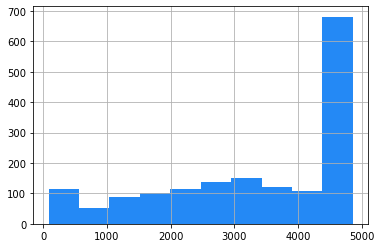

In [18]:
# Measure the length of series for all series
trn.groupby("ticker").count().date.hist()
trn.groupby("ticker").count().date.max()

In [19]:
# List of lags to test: 1 month, 2 months, 1 quarter, 2 quarters, 3 quarters, 1 year -> 20 years
lags = [20, 40] + list(range(60, 60*4, 60)) + list(range(240, 240*2+1, 240))

len(lags)

7

In [ ]:
# Choose a subset of the 934 tickers to test for
ticker_subset = np.random.choice(np.array(list(tickers)), size=200, replace=False)
print("Number of tickers:", len(ticker_subset))
ticker_subset

Number of tickers: 200


array(['603223.SS', '1938.HK', 'PD.TO', '300370.SZ', 'PSX.N', 'ARH.V',
       'WHD.N', '3856.T', '002490.SZ', 'PTMR.KL', 'STEP.TO', 'CLC.WA',
       'PSUR.BA', 'IPWR.OQ', 'GPRK.N', 'TMB.HN', 'MIND.NS', 'ISO.V',
       'BRN.A', '601918.SS', '0757.HK', 'SHLPH.PS', 'HWO.TO', 'CCO.TO',
       '900948.SS', 'MUSA.N', 'DWGL.JK', '1516.TW', 'KEI.TO', '601101.SS',
       'EPSN.OQ', 'SUSCO.BK', 'SBMO.AS', 'ALGS.TA', 'LGGL.CM', 'B7C.MI',
       'SJT.N', 'PPIH.OQ', 'TA.OQ', 'UVN.V', 'PETR4.SA', 'PKN.WA',
       'DEHB.KL', 'DLEKG.TA', 'ET.N', 'CTRA.N', 'OANDO.LG', 'TCC.BK',
       '3315.T', 'PCOR.PS', 'APL.PSX', 'TVE.TO', 'SM.N', '5010.T',
       'AKSOA.OL', 'CKK.V', 'KZTO.KZ', 'CVV.V', 'SWN.N', 'PXS.HM',
       'VOC.N', '8131.T', 'ONVh.V', 'MOIL.CA', 'LXE.V', 'NDRL.CA',
       'SHLX.N', 'OAS.OQ', 'LKOH.MM', 'ABAR.KW', '3167.T', 'KRP.N',
       '600184.SS', '100130.KQ', 'CHX.OQ', 'PPC.PS', 'NCSM.OQ',
       'OKTA.MKE', 'BGPET.BB', 'SHUMBA.BT', 'UMSm.BK', 'POV.HNO',
       '603105.SS', '0968.HK', 'A

In [ ]:
# Create the validation set
traval = trn[trn.ticker.isin(ticker_subset)].copy()
print(traval.shape)
traval["obs_number"] = traval.groupby("ticker").date.rank(method='first', ascending=False).astype(int)

val = traval[traval.obs_number <= 20]
val.head()

(579562, 5)


,ticker,date,market_cap,close_price,currency,obs_number
4461,000096.SZ,2018-12-03,703666005.348054,1.347423,USD,20
4462,000096.SZ,2018-12-04,725253641.094217,1.382731,USD,19
4463,000096.SZ,2018-12-05,724674070.497344,1.368424,USD,18
4464,000096.SZ,2018-12-06,717906223.557902,1.354336,USD,17
4465,000096.SZ,2018-12-07,716624040.920716,1.358881,USD,16


In [ ]:
train = traval[traval.obs_number > 20].copy()
train["obs_number"] = train.groupby("ticker").date.rank(method='first', ascending=False).astype(int)

train.head()

,ticker,date,market_cap,close_price,currency,obs_number
0,000096.SZ,2000-07-24,461931447.619507,0.87487,USD,4461
1,000096.SZ,2000-07-25,487445197.289756,0.923192,USD,4460
2,000096.SZ,2000-07-26,476291125.175129,0.902067,USD,4459
3,000096.SZ,2000-07-27,481888565.458432,0.912668,USD,4458
4,000096.SZ,2000-07-28,490252916.878034,0.928509,USD,4457


In [ ]:
def calculate_mean_mapes(ls, tcks):
    mean_mapes = []

    it = tqdm(total=len(ls)*len(tcks))

    for lag in ls:
        it.set_postfix(dict(lag=lag))
        mapes = []
        for ticker in tcks:
            series = train.loc[(train.ticker == ticker) & (train.obs_number <= lag), ["date", "market_cap"]].set_index("date").squeeze()

            mod = pm.arima.AutoARIMA(seasonal=False, suppress_warnings=True, n_jobs=-1, stepwise=False)
            mod.fit(series)

            forecast = mod.predict(20)
            actual = val.loc[(val.ticker == ticker), ["date", "market_cap"]].set_index("date").squeeze()
            mapes.append(mape(actual, forecast))
            it.update()

        mean_mapes.append(np.mean(mapes))

    return mean_mapes

In [ ]:
mmapes = calculate_mean_mapes(lags[::2], ticker_subset[:100])

 16%|███████████▊                                                             | 65/400 [00:21<01:03,  5.27it/s, lag=20]C:\Users\larslank\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
 41%|█████████████████████████████▋                                          | 165/400 [00:47<00:58,  4.03it/s, lag=60]C:\Users\larslank\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
100%|███████████████████████████████████████████████████████████████████████| 400/400 [02:34<00:00,  2.58it/s, lag=480]


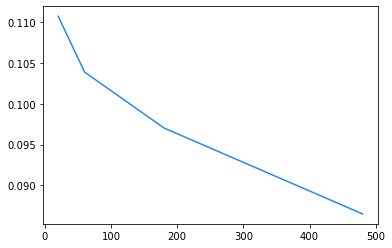

In [ ]:
plt.plot(lags[::2], mmapes);

In [ ]:
min(zip(lags[::2], mmapes), key=lambda x: x[1])

(480, 0.08651150254051465)

In [ ]:
# Do a more thorough search around the optimal above
mmapes = calculate_mean_mapes(lags[1:9], ticker_subset)

  5%|███▉                                                                    | 65/1200 [00:14<05:22,  3.51it/s, lag=40]C:\Users\larslank\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
 22%|███████████████▋                                                       | 265/1200 [01:03<03:49,  4.08it/s, lag=60]C:\Users\larslank\Anaconda3\lib\site-packages\pmdarima\arima\auto.py:460: UserWarning: Input time-series is completely constant; returning a (0, 0, 0) ARMA.
  warnings.warn('Input time-series is completely constant; '
100%|█████████████████████████████████████████████████████████████████████| 1200/1200 [07:35<00:00,  2.63it/s, lag=480]


In [ ]:
lags

[20, 40, 60, 120, 180, 240, 480]

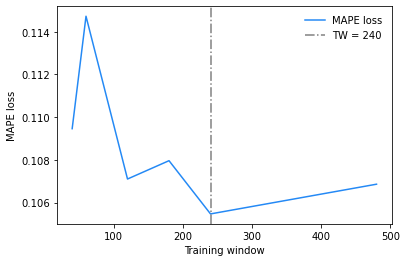

In [ ]:
plt.xlabel("Training window")
plt.ylabel("MAPE loss")
plt.plot(lags[1:], mmapes, label="MAPE loss")
plt.axvline(x=240, label="TW = 240", color="gray", linestyle="-.")
plt.legend(frameon=False);

In [ ]:
# Finding the lag with the lowest loss
opt = min(zip(lags[1:9], mmapes), key=lambda x: x[1])
opt

(240, 0.10546923023428832)

From the above, we can conclude that ARIMA performs best when using the previous 240 datapoints, i.e., around a quarter of data before the month it shall predict.

## Train ARIMA models on 2018 data 🎯

And upload the result to WandB


In [20]:
# Use the above results and get the last quarter of data in the training set
trn = trn[(trn.date >= "2018-01-01")].copy()
print(trn.shape[0])

408494


In [21]:
trained_models = dict()

In [ ]:
arima_args = dict(
    seasonal=False,
    with_intercept=True,
    max_p=10, max_d=2, max_q=10,
    max_order=10,
    stepwise=True, n_jobs=1,    
)

In [ ]:
for ticker, df in tqdm(trn.groupby("ticker")):

    series = df.loc[:, ["date", "market_cap"]].set_index("date").squeeze()
    
    mod = pm.arima.AutoARIMA(**arima_args)
    mod.fit(series)

    trained_models[ticker] = mod

In [44]:
model_orders = {ticker: mod.model_.order for ticker, mod in trained_models.items()}

In [ ]:
filename = "arima-trained-4Q.pickle"
metadata = {
    "type": "ARIMA",
    "n_models": len(trained_models),
    "training_window": 240,
    "arima_args": arima_args,
    "model_orders": json.dumps(model_orders),
}

put_stat_models(filename, trained_models, metadata, project="master")

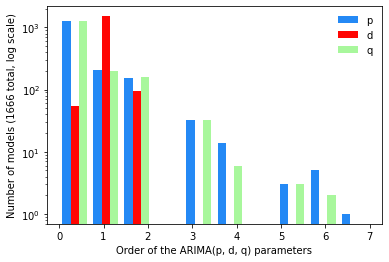

In [68]:
plt.hist(np.array([list(orders) for orders in model_orders.values()]), label=["p", "d", "q"], align="mid", log=True)
plt.xlabel("Order of the ARIMA(p, d, q) parameters")
plt.ylabel(f"Number of models ({len(trained_models)} total, log scale)")
plt.legend(frameon=False);

# Predict for the test set

## Get data and predict

In [ ]:
artifact_name = "arima-trained-4Q:latest"
trained_models = get_stat_models(artifact_name, project="master")

In [ ]:
ob_num = list(range(1, 21))
out = dict(ticker=[], year=[], month=[], obs_number=[], market_cap=[])

tst = data[data.date >= "2018-12-01"].copy()

daterange = pd.date_range(start="2018-12-31", end="2022-03-31", freq="M")
pbar = tqdm(total=len(daterange)*len(trained_models), position=0)

for date in daterange:
    df = tst[tst.date <= date]
    for ticker, model in trained_models.items():
        pbar.update()
        d = df.loc[df.ticker == ticker, ["date", "market_cap"]].set_index("date").squeeze()[-10:]
        
        if len(d) < 1:
            continue

        model.update(y=d, maxiter=0)
        forec = model.predict(20)

        out["ticker"].extend([ticker] * 20)
        out["year"].extend([date.year] * 20)
        out["month"].extend([date.month] * 20)
        out["market_cap"].extend(forec)
        out["obs_number"].extend(ob_num)

forec_df = pd.DataFrame(out)

 33%|█████████████████████████▍                                                  | 22300/66640 [09:06<24:12, 30.53it/s]

In [ ]:
put_dataset(forec_df, "arima-4Q-forecast-19-22.feather", "master", type_="forecast", metadata={"arima_args": arima_args})

forec_df

## Calculate MAPE

In [ ]:
ticker_subset = set(tst.ticker) & set(forec_df.ticker)

In [ ]:
a = tst.set_index("ticker").loc[ticker_subset, :].reset_index().set_index(["ticker", "obs_number"]).drop(columns=["close_price", "currency", "date"])
f = forec_df.set_index("ticker").loc[ticker_subset, :].reset_index().set_index(["ticker", "obs_number"])

errors = ((a - f).abs() / a.abs())

In [ ]:
errors[errors < 1].groupby("ticker").mean().mean().item()

0.11407436573174416

In [ ]:
errors.groupby("ticker").mean().mean().item()

0.11904643671200661

In [ ]:
# Check sMAPE as well for reference
2*((a - f).abs() / (a.abs() + f.abs())).dropna().groupby("ticker").mean().mean().item()

0.1508614212073925

# Forecast for Naïve as well

To establish a baseline

In [ ]:
# Need only one value because naïve will predict the same for all future values
last_value = trn.drop_duplicates(subset=["ticker"], keep="last").drop(columns=["close_price", "currency", "date"]).set_index("ticker")

last_value.head()

,market_cap
ticker,
000096.SZ,711445177.642791
000159.SZ,295766554.600941
000440.KQ,37383424.577752
000552.SZ,851522927.496182
000554.SZ,358586694.401957


In [ ]:
# MAPE for naïve
errors = ((a - last_value).abs() / a.abs()).dropna()
errors.groupby("ticker").mean().mean().item()

0.08600014724897861